# Deep Learning Final Project: Game of Life

Neil Chen, University of Colorado Boulder

Apr 20, 2025

## 1. Project Description

In this project I'd like to explore how to use deep learning models to learn the rules of [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life).

Game of Life is a simulation with **cellular automation**, with only a few simple rules it can evolve to interesting patterns.

The game rules are:

> The universe of the Game of Life is an infinite, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead (or populated and unpopulated, respectively). Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

- Any live cell with fewer than two live neighbours dies, as if by underpopulation. (Die because of loneliness)
- Any live cell with two or three live neighbours lives on to the next generation.
- Any live cell with more than three live neighbours dies, as if by overpopulation. (Die because of crowded)
- Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

I choose this topic because:

1. It's quite fun
2. I want to know whether or not deep learning models can learn the rules of the game.
3. The rules are deterministic, so at each step the state of the cells is fully predictable, which make it possible for me to evaluate model's performance by accuracy. (Unlike other board games which evolves too players to compete with each other, like [Othello](https://en.wikipedia.org/wiki/Reversi), or [Go](https://en.wikipedia.org/wiki/Go_(game) and so on., which could be more difficult to evaluate the performance of the models).


## 2. Prepare the Data

Since the game is not competitive, we can randomly generate the data based on the game rules.

We will generate 1,000 samples (sequences) on a 40x40 sized board, with sequence length 30, and when generating the initial random board, we will generate 30% live cells and the others are dead cells.


In [84]:
import numpy as np
import os

# Update grid to the next step, according to the rules of game of life
def update_grid(grid):
    N = grid.shape[0]
    new_grid = grid.copy()
    for i in range(N):
        for j in range(N):
            # number of neighbors
            neighbors = np.sum(grid[max(0, i-1):i+2, max(0, j-1):j+2]) - grid[i, j]

            # die because of loneliness or crowded
            if grid[i, j] == 1 and (neighbors < 2 or neighbors > 3):
                new_grid[i, j] = 0
            # reproduction
            elif grid[i, j] == 0 and neighbors == 3:
                new_grid[i, j] = 1
    return new_grid

# Generate training data
def generate_data(num_samples, grid_size=20, steps=15, live_prob=0.3):
    data = []
    for _ in range(num_samples):
        grid = np.random.choice([0, 1], size=(grid_size, grid_size), p=[1-live_prob, live_prob])
        sequence = [grid]
        # evolving
        for _ in range(steps):
            grid = update_grid(grid)
            sequence.append(grid)
        data.append(sequence)
    return np.array(data)

# Save the data to NumPy arrays
def save_data(data, output_dir="data"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    np.save(os.path.join(output_dir, "life_data_optimized.npy"), data)
    print(f"Saved data to: {output_dir}/life_data_optimized.npy")

# Verify the data shape and proportion of live cells
def verify_data(data):
    print(f"Shape of data: {data.shape}")
    print(f"Shape of sample sequence: {data[0].shape}")
    print("Sample initial state:\n", data[0, 0])
    print("Sample last state: \n", data[0, -1])
    # Calculate mean live cell proportion for each time step across all samples
    live_props = [np.mean(seq) for seq in data[:, :, :, :]]
    print(f"Average proportion of live cells across all samples and all steps: {np.mean(live_props):.3f} ± {np.std(live_props):.3f}")

def generate_training_data():
    num_samples = 1000
    grid_size = 40
    steps = 30
    live_prob = 0.3
    
    print("Generating data...")
    data = generate_data(num_samples, grid_size, steps, live_prob)
    verify_data(data)
    save_data(data)

generate_training_data()

Generating data...
Shape of data: (1000, 31, 40, 40)
Shape of sample sequence: (31, 40, 40)
Sample initial state:
 [[0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]
 ...
 [0 0 1 ... 0 1 1]
 [0 0 0 ... 1 1 0]
 [0 1 0 ... 0 0 0]]
Sample last state: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Average proportion of live cells across all samples and all steps: 0.192 ± 0.015
Saved data to: data/life_data_optimized.npy


## 3. Exploratory Data Analysis (EDA)

First, let's check out some samples, to see what the game grid look like, and how does the state of the grids evolves over time (steps).

Grid Evolution (Initial state, step 10, 20, 30):


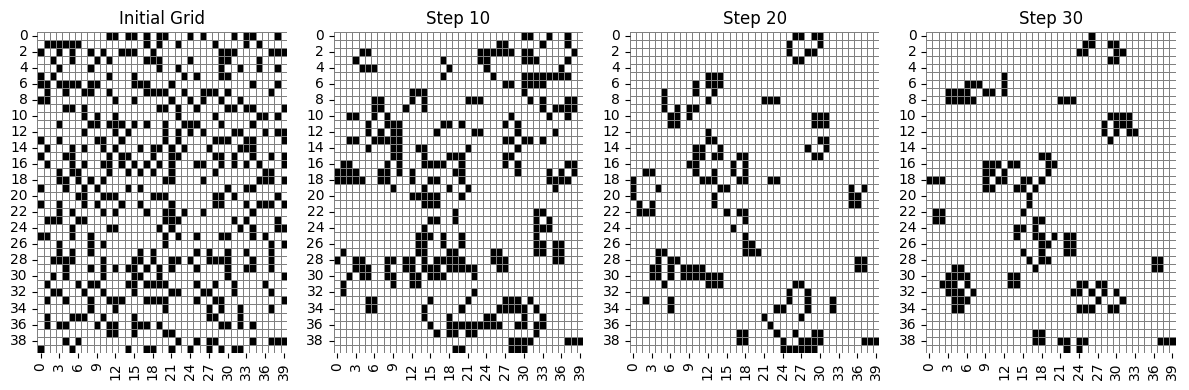

Grid Full Evolution (30 steps)


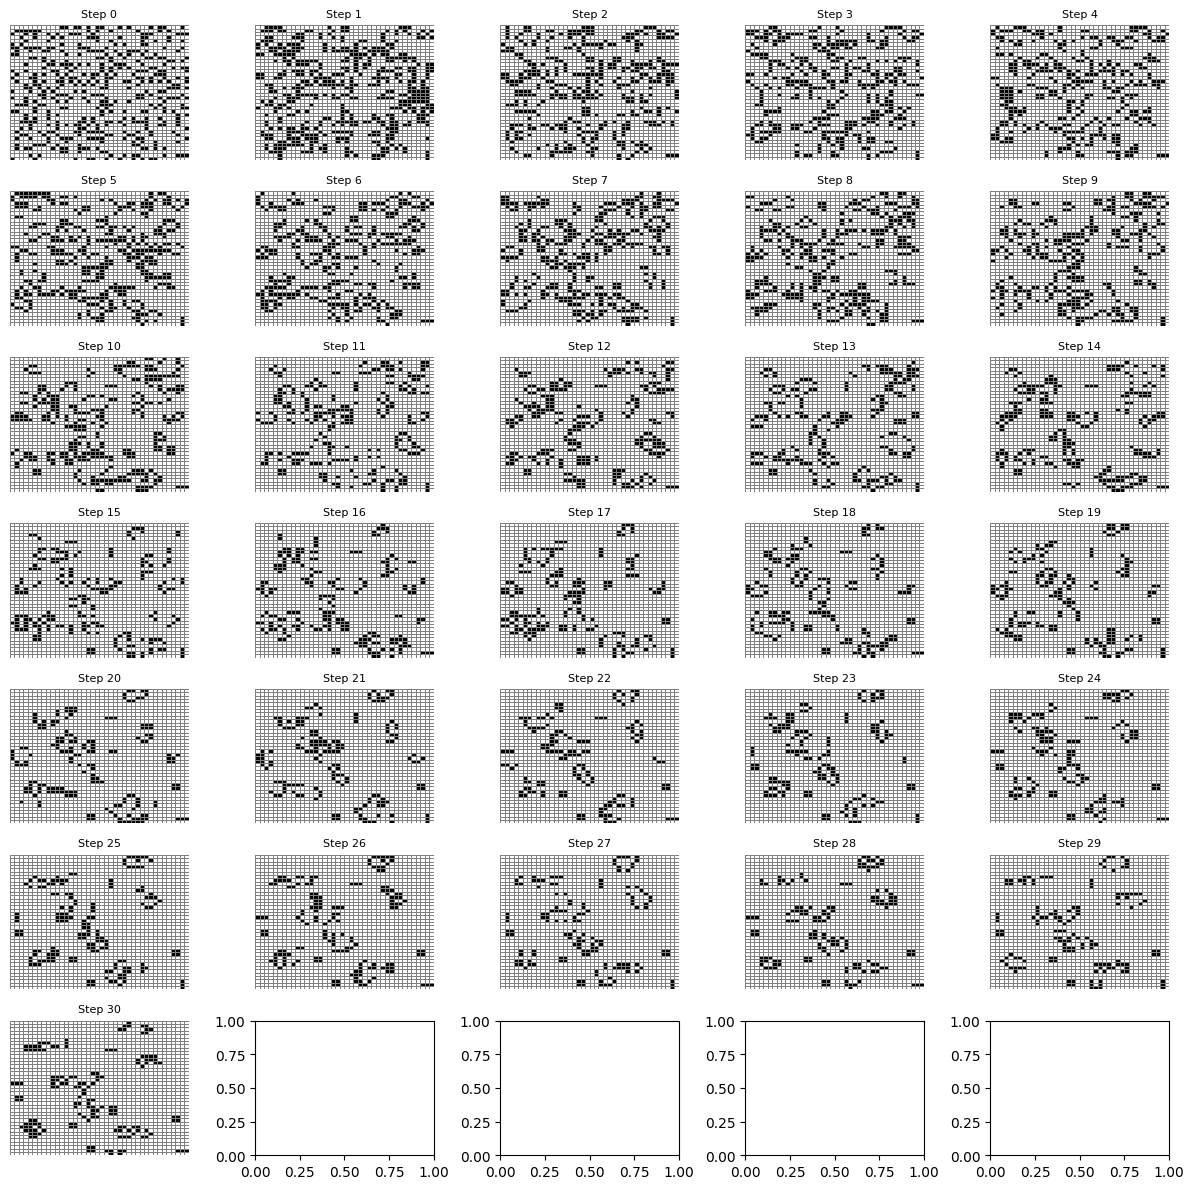

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the original data
data = np.load('data/life_data_optimized.npy')  # Shape: (1000, 31, 40, 40)

# Plot grid evolution with a heatmap
def plot_grid_evolution(data, sample_idx=0):
    print("Grid Evolution (Initial state, step 10, 20, 30):")
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    steps = [0, 10, 20, 30]  # Initial state, step 10, 20, 30
    titles = ['Initial Grid', 'Step 10', 'Step 20', 'Step 30']
    for i, step in enumerate(steps):
        sns.heatmap(data[sample_idx, step], cmap='binary', cbar=False, 
                    ax=axes[i], linewidths=0.5, linecolor='gray')
        axes[i].set_title(titles[i])
    plt.tight_layout()
    plt.savefig('grid_evolution_bordered.png')
    plt.show()

# Plot full sequence evolution
def plot_full_sequence_evolution(data, sample_idx=0):
    print("Grid Full Evolution (30 steps)")
    fig, axes = plt.subplots(7, 5, figsize=(12, 12))  # 7x5 grid for 16 steps
    axes = axes.flatten()
    for step in range(31):  # 0 to 30 steps
        sns.heatmap(data[sample_idx, step], cmap='binary', cbar=False, 
                    ax=axes[step], linewidths=0.5, linecolor='gray')
        axes[step].set_title(f'Step {step}', fontsize=8)
        axes[step].set_xticks([])
        axes[step].set_yticks([])  # Remove axis ticks for clarity
    plt.tight_layout()
    plt.savefig('full_sequence_evolution.png')
    plt.show()

# Run the EDA
plot_grid_evolution(data, sample_idx=0)
plot_full_sequence_evolution(data, sample_idx=0)

Next, we will check how the proportion of live cells changes over time.

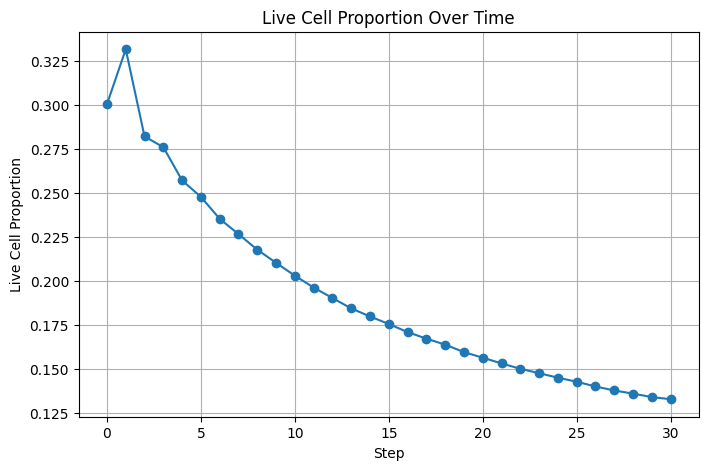

In [44]:
# Proportion of live cells over time
def plot_live_cell_proportion(data):
    live_props = np.mean(data, axis=(0, 2, 3))  # proportion of live cells in each step
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(live_props)), live_props, marker='o')
    plt.title('Live Cell Proportion Over Time')
    plt.xlabel('Step')
    plt.ylabel('Live Cell Proportion')
    plt.grid(True)
    plt.savefig('live_cell_proportion.png')
    plt.show()

# Run the EDA
plot_live_cell_proportion(data)

Also we will check the frequency distribution of the number of cells in initial states.

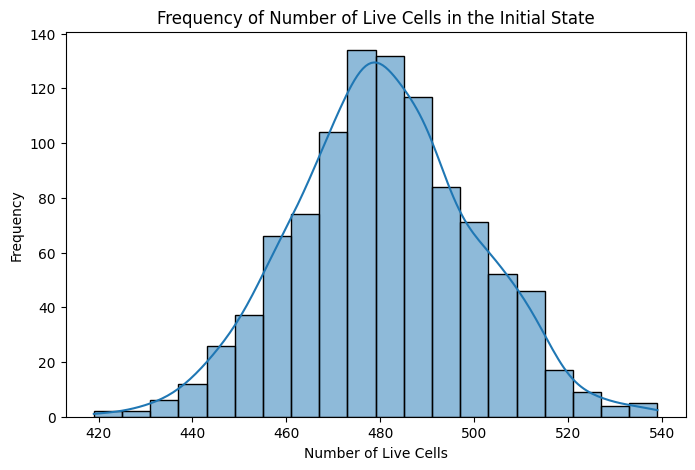

In [45]:
# Histgram of Live Cells Distribution
def plot_live_cell_distribution(data):
    live_counts = np.sum(data[:, 0, :, :], axis=(1, 2))  # Initial number of live cells
    plt.figure(figsize=(8, 5))
    sns.histplot(live_counts, bins=20, kde=True)
    plt.title('Frequency of Number of Live Cells in the Initial State')
    plt.xlabel('Number of Live Cells')
    plt.ylabel('Frequency')
    plt.savefig('live_cell_distribution.png')
    plt.show()

plot_live_cell_distribution(data)

 The number of live cells in the initial state is around 420~540, with max value 480, which translates to the exactly the proportion of live cells we configured: 480 / 40 / 40 = 0.3.

And cluster size distributions as well.

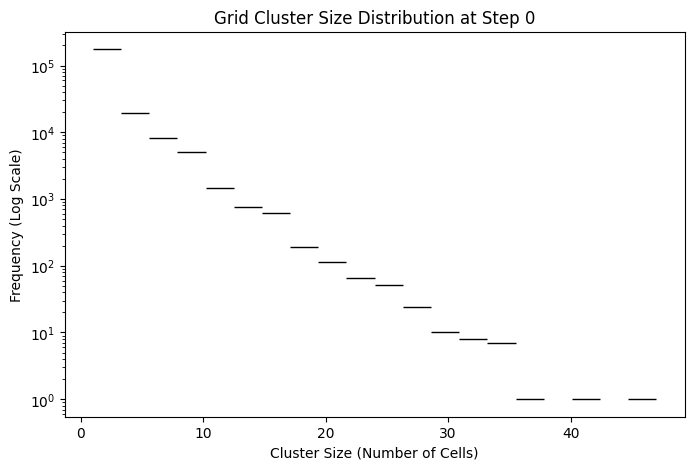

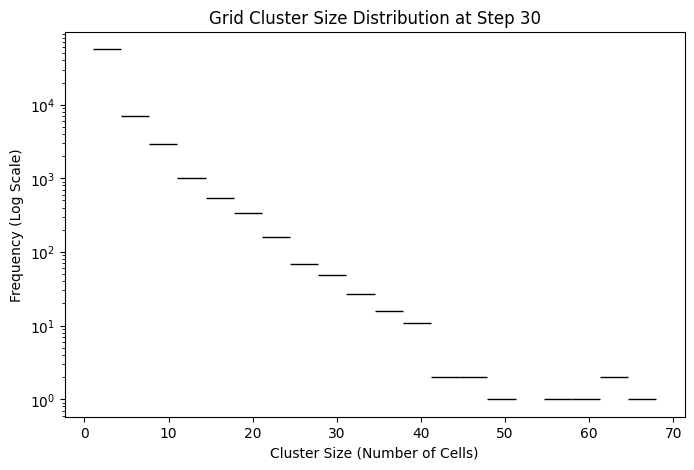

In [46]:
from scipy.ndimage import label

# Plot Cluster Sizes
def plot_cluster_sizes(data, step):
    cluster_sizes = []
    for grid in data[:, step, :, :]:  # Initial grid
        labeled, num_features = label(grid)  # label the connected regions
        sizes = [np.sum(labeled == i) for i in range(1, num_features+1)]
        cluster_sizes.extend(sizes)
    plt.figure(figsize=(8, 5))
    sns.histplot(cluster_sizes, bins=20, log_scale=(False, True))
    plt.title(f'Grid Cluster Size Distribution at Step {step}')
    plt.xlabel('Cluster Size (Number of Cells)')
    plt.ylabel('Frequency (Log Scale)')
    plt.savefig(f'cluster_sizes_step_{step}.png')
    plt.show()

plot_cluster_sizes(data, 0)
plot_cluster_sizes(data, 30)

Now let's pot some examples of the clusters, see if we can find some interesting patterns.

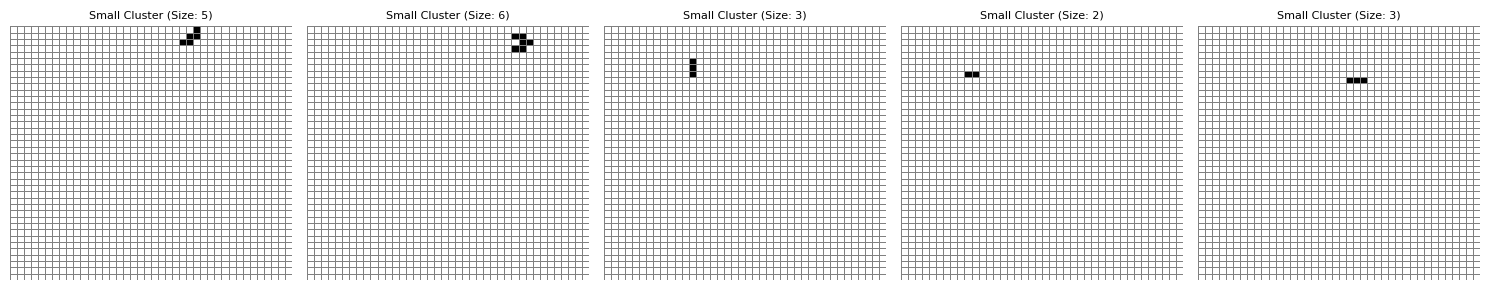

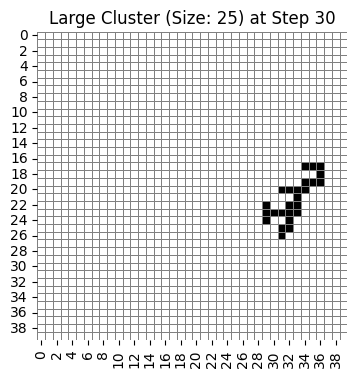

In [48]:
# Plot multiple small cluster examples
def plot_cluster_examples(data, step, small_size=10, large_size=20, num_small=5):
    small_clusters, large_clusters = [], []
    for idx, grid in enumerate(data[:, step, :, :]):
        labeled, num_features = label(grid)
        for i in range(1, num_features+1):
            cluster = (labeled == i).astype(int)
            size = np.sum(cluster)
            if size <= small_size:
                small_clusters.append((idx, cluster, size))
            elif size > large_size:
                large_clusters.append((idx, cluster, size))
    
    # Select up to num_small small clusters and one large cluster
    if small_clusters and large_clusters:
        # Randomly select num_small clusters (or all if fewer)
        selected_small = small_clusters[:min(num_small, len(small_clusters))]
        large_idx, large_cluster, large_size = large_clusters[0]
        
        # Plot small clusters in a row
        fig, axes = plt.subplots(1, len(selected_small), figsize=(3 * len(selected_small), 3))
        if len(selected_small) == 1:
            axes = [axes]  # Handle single subplot case
        for i, (idx, cluster, size) in enumerate(selected_small):
            sns.heatmap(cluster, cmap='binary', cbar=False, 
                        ax=axes[i], linewidths=0.5, linecolor='gray')
            axes[i].set_title(f'Small Cluster (Size: {size})', fontsize=8)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        plt.tight_layout()
        plt.savefig(f'small_clusters_step_{step}.png')
        plt.show()
        
        # Plot large cluster
        plt.figure(figsize=(4, 4))
        sns.heatmap(large_cluster, cmap='binary', cbar=False, 
                    linewidths=0.5, linecolor='gray')
        plt.title(f'Large Cluster (Size: {large_size}) at Step {step}')
        plt.savefig(f'large_cluster_step_{step}.png')
        plt.show()

plot_cluster_examples(data, 30, num_small=5)        

Identified interesting patterns:

- Blinker
- Sliding blocks?

Is there any fully dead grids after a period of time?

In [50]:
# Check proportion of fully dead grids at step 30
dead_grids = np.sum(data[:, 30, :, :], axis=(1, 2)) == 0
print(f"Proportion of fully dead grids at step 30: {np.mean(dead_grids):.3f}")

Proportion of fully dead grids at step 30: 0.000


### Insights from the EDA

1. The generated Life of Game sequence data is correct, according to the game rules.
2. The proportion of live cells slowly drops while the game evolves, with 30 steps it still doesn't reach the final stable state.
3. The number of live cells is normally distributed, with max value 480, which translates exactly to the pre-configured proportion of live cells, which is 0.3.
4. The size of the clusters are mostly quite small, where some interesting patterns found.
5. There are no fully dead grids, the data quality is quite good, no need to do any cleaning.

## 4. Model Training

### 4.1 Pre-processing of the Data

Firstly we will load the generated training data, and split it into training, validation and test datasets.

At each step t of a sequence, we have `seq[t]` as the input data, and `seq[t+1]` as the label.


In [85]:
import tensorflow as tf

# Load and prepare data
def load_and_prepare_data(file_path='data/life_data_optimized.npy'):
    data = np.load(file_path)
    print(f"Data shape: {data.shape}")  # (1000, 31, 40, 40)
    
    # Extract state pairs (t -> t+1)
    inputs, labels = [], []
    for seq in data:
        for t in range(len(seq)-1):
            inputs.append(seq[t])  # Shape: (40, 40)
            labels.append(seq[t+1])  # Shape: (40, 40)
    inputs = np.array(inputs)  # Shape: (30000, 40, 40, 1)
    labels = np.array(labels)  # Shape: (30000, 40, 40, 1)
    
    # Add channel dimension for CNN: (num_pairs, 40, 40, 1)
    inputs = inputs[..., np.newaxis]  # Shape: (num_pairs, 40, 40, 1)
    labels = labels[..., np.newaxis]  # Shape: (num_pairs, 40, 40, 1)

    # Split into train, validation, test
    total_samples = inputs.shape[0]
    train_size = int(0.8 * total_samples)
    val_size = int(0.1 * total_samples)
    train_inputs, train_labels = inputs[:train_size], labels[:train_size]
    val_inputs, val_labels = inputs[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_inputs, test_labels = inputs[train_size+val_size:], labels[train_size+val_size:]
    
    print(f"Train shape: {train_inputs.shape}, Val shape: {val_inputs.shape}, Test shape: {test_inputs.shape}")
    return train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels

# Create TensorFlow datasets
def create_datasets(train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels, batch_size=32):
    # every sample is in shape: (input: [40, 40, 1], label: [40, 40, 1])
    train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(batch_size)
    return train_dataset, val_dataset, test_dataset

train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels = load_and_prepare_data()
train_dataset, val_dataset, test_dataset = create_datasets(
    train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels
)

Data shape: (1000, 31, 40, 40)
Train shape: (24000, 40, 40, 1), Val shape: (3000, 40, 40, 1), Test shape: (3000, 40, 40, 1)


### 4.2 Helper functions for model training and evaluation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout

# Train model and plot results
def train_and_plot(model, train_dataset, val_dataset, model_name, epochs=10):
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)
    
    # Plot loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png')
    plt.show()
    
    return history

# Evaluate model
def evaluate_model(model, test_dataset, model_name):
    try:
        test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
        print(f"{model_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
        return test_loss, test_acc
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None, None


### 4.3 MLP Model (baseline)

We will try with a simple Multiple Layer Perceptron (MLP) model first, as a baseline.

It includes a input layer of 1600 neurons, and output layer with 1600 neurons as well, to match with the shape of the shape of the training input data `seq[t]` and label `seq[t+1]`.

Also it has a hidden layer with 64 neurons, to learn any latent features which reflect the mapping rules.

In [ ]:
# Build MLP model (baseline)
def build_mlp_model():
    model = Sequential([
        Flatten(input_shape=(40, 40, 1)),  # Flatten 40x40x1 to 1600
        Dense(64, activation='relu'),
        Dense(1600, activation='sigmoid'),  # Output 1600 (40x40)
        tf.keras.layers.Reshape((40, 40, 1))  # Reshape to (40, 40, 1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Training MCP model...
Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 0.4844 - accuracy: 0.8092 - val_loss: 0.4612 - val_accuracy: 0.8137
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.4486 - accuracy: 0.8110 - val_loss: 0.4483 - val_accuracy: 0.8113
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.4363 - accuracy: 0.8078 - val_loss: 0.4410 - val_accuracy: 0.8076
Epoch 4/10
750/750 [==============================] - 3s 3ms/step - loss: 0.4302 - accuracy: 0.8055 - val_loss: 0.4376 - val_accuracy: 0.8069
Epoch 5/10
750/750 [==============================] - 3s 3ms/step - loss: 0.4271 - accuracy: 0.8047 - val_loss: 0.4358 - val_accuracy: 0.8059
Epoch 6/10
750/750 [==============================] - 3s 3ms/step - loss: 0.4253 - accuracy: 0.8045 - val_loss: 0.4346 - val_accuracy: 0.8050
Epoch 7/10
750/750 [==============================] - 3s 3ms/step - loss: 0.4240 - accuracy: 0.8043 - val_loss: 0.4338 - val_a

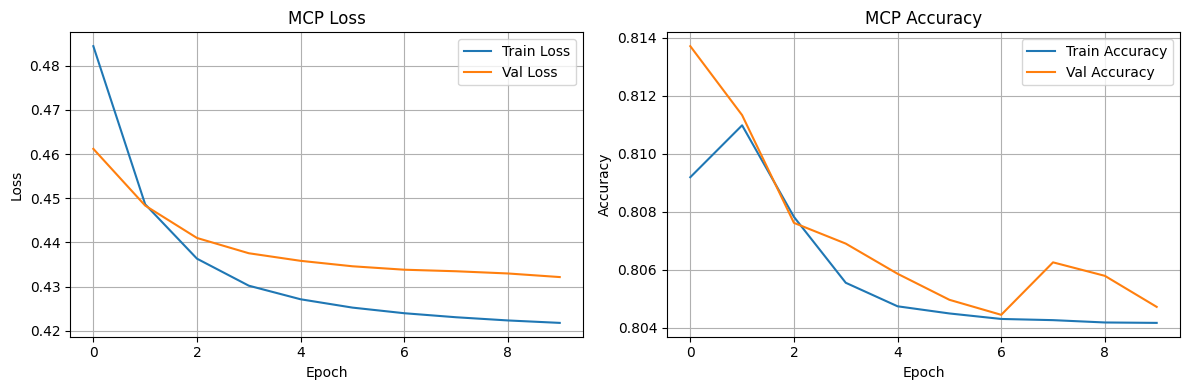

MCP - Test loss: 0.4384, Test accuracy: 0.8012


In [ ]:
# Train MLP
mlp_model = build_mlp_model()
print("Training MLP model...")
mlp_history = train_and_plot(mlp_model, train_dataset, val_dataset, 'MLP')

# Evaluate models
evaluate_model(mlp_model, test_dataset, 'MLP')

### 4.4 Hyper-parameter Tuning for MLP

The acuracy is about `80%`, which is not quite high. Let's try to do some hyper-parameter tuning.

There could be a few reasons:

- The latent layer may have too few nodes, which might be not enough learn all the rule mappings.
- The model could overfit too early and stops to learn.
- Can try with learning rates to avoid underfit or overfit.

The approach is to try some different setups with `grid search`:

- Try with more neurons in the hidden layer: [64, 128, 256]
- Try `dropout_rates` to avoid the model overfit: [0.0, 0.2]
- Use different learning rates: [0.001, 0.0005]


Tuning MCP hyperparameters...

Testing MCP: hidden_units=64, dropout_rate=0.0, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4856 - accuracy: 0.8095 - val_loss: 0.4623 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4495 - accuracy: 0.8110 - val_loss: 0.4478 - val_accuracy: 0.8121
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4369 - accuracy: 0.8080 - val_loss: 0.4416 - val_accuracy: 0.8082
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4307 - accuracy: 0.8057 - val_loss: 0.4385 - val_accuracy: 0.8070
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4274 - accuracy: 0.8049 - val_loss: 0.4364 - val_accuracy: 0.8053
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4255 - accuracy: 0.8046 - val_loss: 0.4353 - val_accuracy: 0.8054
Epoch 7/20
750/750 [============================

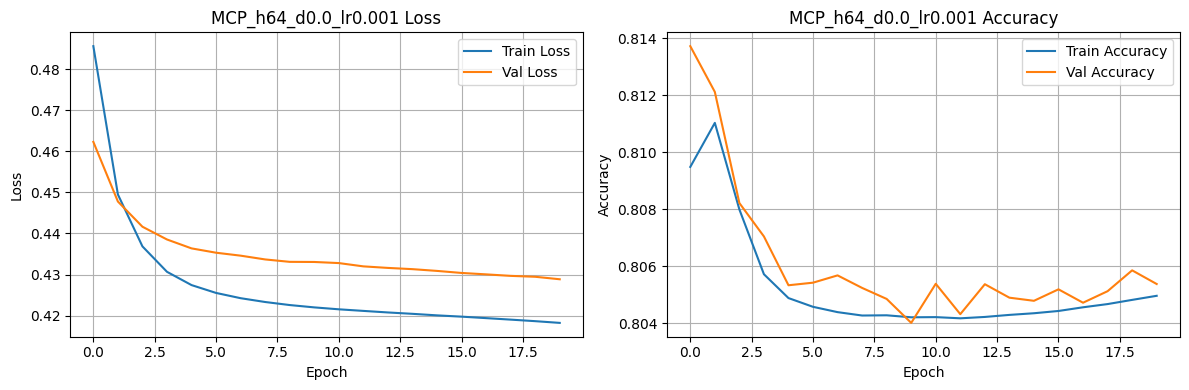

MCP_h64_d0.0_lr0.001 - Test loss: 0.4346, Test accuracy: 0.8019

Testing MCP: hidden_units=64, dropout_rate=0.0, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4990 - accuracy: 0.8075 - val_loss: 0.4814 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4656 - accuracy: 0.8116 - val_loss: 0.4602 - val_accuracy: 0.8137
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.4504 - accuracy: 0.8115 - val_loss: 0.4506 - val_accuracy: 0.8132
Epoch 4/20
750/750 [==============================] - 3s 3ms/step - loss: 0.4408 - accuracy: 0.8103 - val_loss: 0.4443 - val_accuracy: 0.8111
Epoch 5/20
750/750 [==============================] - 3s 3ms/step - loss: 0.4343 - accuracy: 0.8082 - val_loss: 0.4410 - val_accuracy: 0.8077
Epoch 6/20
750/750 [==============================] - 3s 3ms/step - loss: 0.4300 - accuracy: 0.8065 - val_loss: 0.4382 - val_accuracy: 0.8069
Epoch 7/20
750

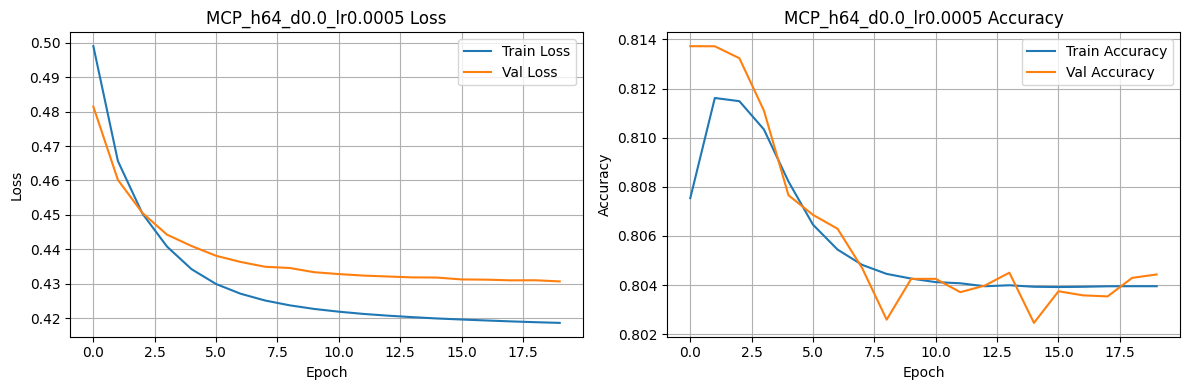

MCP_h64_d0.0_lr0.0005 - Test loss: 0.4365, Test accuracy: 0.8014

Testing MCP: hidden_units=64, dropout_rate=0.2, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 0.4880 - accuracy: 0.8091 - val_loss: 0.4644 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4574 - accuracy: 0.8115 - val_loss: 0.4507 - val_accuracy: 0.8136
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4488 - accuracy: 0.8107 - val_loss: 0.4461 - val_accuracy: 0.8131
Epoch 4/20
750/750 [==============================] - 7s 9ms/step - loss: 0.4451 - accuracy: 0.8100 - val_loss: 0.4422 - val_accuracy: 0.8129
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4427 - accuracy: 0.8098 - val_loss: 0.4401 - val_accuracy: 0.8128
Epoch 6/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4412 - accuracy: 0.8097 - val_loss: 0.4389 - val_accuracy: 0.8127
Epoch 7/20
750

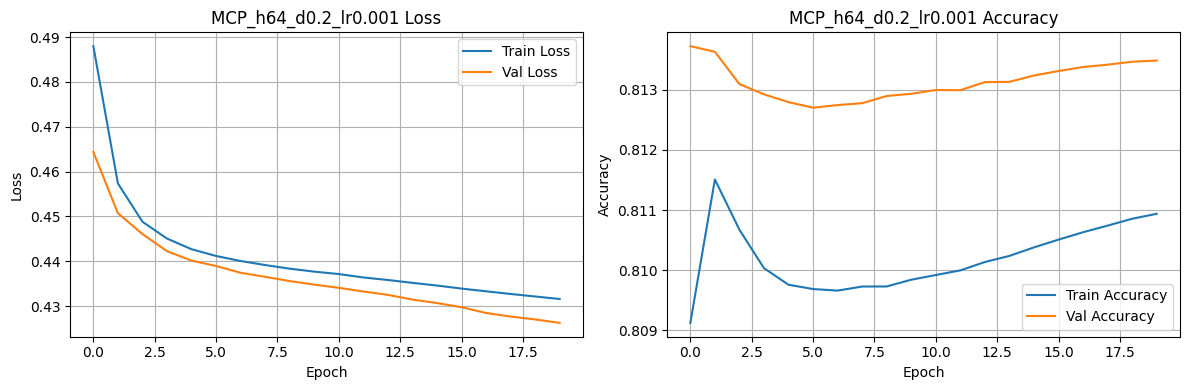

MCP_h64_d0.2_lr0.001 - Test loss: 0.4315, Test accuracy: 0.8104

Testing MCP: hidden_units=64, dropout_rate=0.2, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 7s 8ms/step - loss: 0.5011 - accuracy: 0.8070 - val_loss: 0.4819 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4702 - accuracy: 0.8116 - val_loss: 0.4636 - val_accuracy: 0.8137
Epoch 3/20
750/750 [==============================] - 6s 9ms/step - loss: 0.4584 - accuracy: 0.8116 - val_loss: 0.4547 - val_accuracy: 0.8137
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4517 - accuracy: 0.8114 - val_loss: 0.4490 - val_accuracy: 0.8135
Epoch 5/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4475 - accuracy: 0.8108 - val_loss: 0.4454 - val_accuracy: 0.8132
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4449 - accuracy: 0.8103 - val_loss: 0.4429 - val_accuracy: 0.8130
Epoch 7/20
750

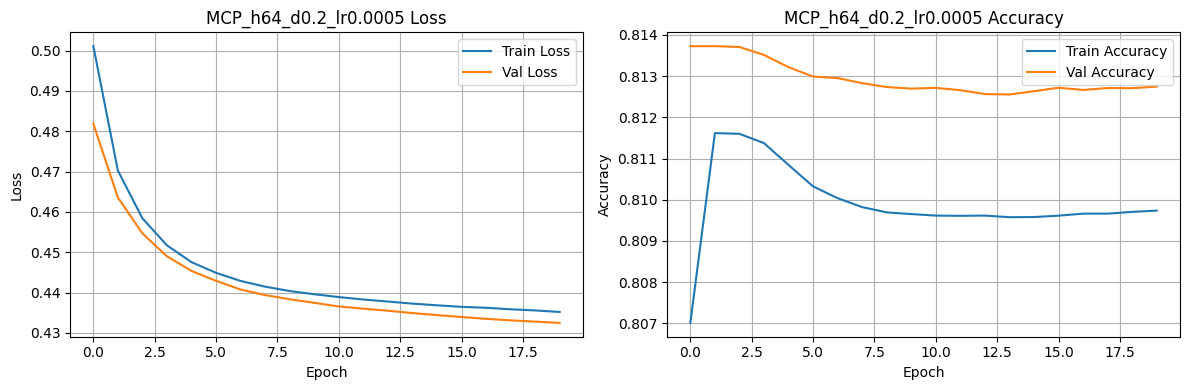

MCP_h64_d0.2_lr0.0005 - Test loss: 0.4383, Test accuracy: 0.8096

Testing MCP: hidden_units=128, dropout_rate=0.0, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4734 - accuracy: 0.8100 - val_loss: 0.4492 - val_accuracy: 0.8133
Epoch 2/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4327 - accuracy: 0.8078 - val_loss: 0.4341 - val_accuracy: 0.8066
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4180 - accuracy: 0.8025 - val_loss: 0.4283 - val_accuracy: 0.8024
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4109 - accuracy: 0.8008 - val_loss: 0.4257 - val_accuracy: 0.8004
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4070 - accuracy: 0.8004 - val_loss: 0.4240 - val_accuracy: 0.7989
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.4045 - accuracy: 0.8003 - val_loss: 0.4233 - val_accuracy: 0.7975
Epoch 7/20
75

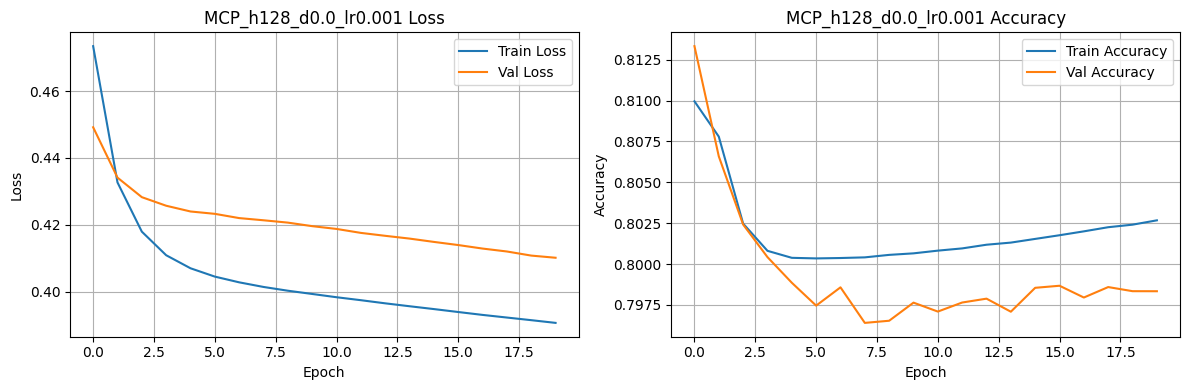

MCP_h128_d0.0_lr0.001 - Test loss: 0.4164, Test accuracy: 0.7952

Testing MCP: hidden_units=128, dropout_rate=0.0, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4887 - accuracy: 0.8087 - val_loss: 0.4655 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.4504 - accuracy: 0.8115 - val_loss: 0.4466 - val_accuracy: 0.8131
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4325 - accuracy: 0.8086 - val_loss: 0.4358 - val_accuracy: 0.8069
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4204 - accuracy: 0.8036 - val_loss: 0.4294 - val_accuracy: 0.8028
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.4131 - accuracy: 0.8010 - val_loss: 0.4259 - val_accuracy: 0.7998
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.4086 - accuracy: 0.8000 - val_loss: 0.4239 - val_accuracy: 0.7982
Epoch 7/20
7

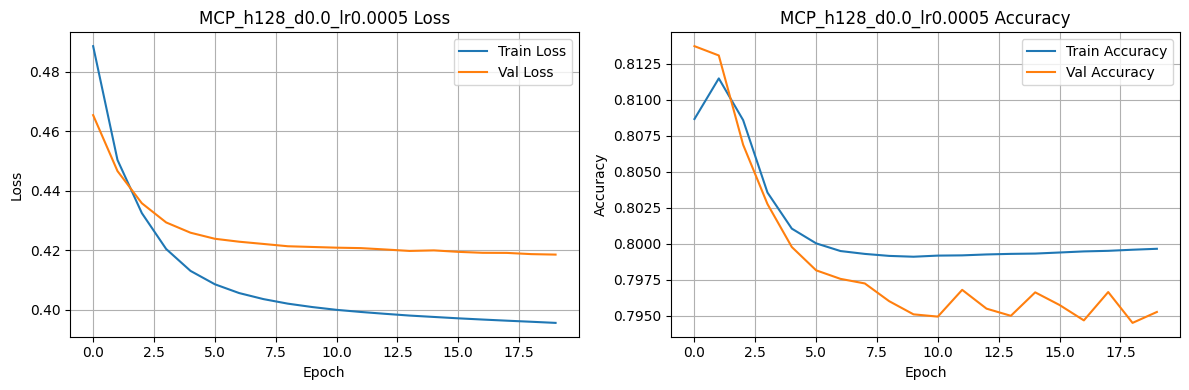

MCP_h128_d0.0_lr0.0005 - Test loss: 0.4246, Test accuracy: 0.7919

Testing MCP: hidden_units=128, dropout_rate=0.2, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4789 - accuracy: 0.8096 - val_loss: 0.4540 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.4449 - accuracy: 0.8103 - val_loss: 0.4396 - val_accuracy: 0.8121
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4346 - accuracy: 0.8077 - val_loss: 0.4331 - val_accuracy: 0.8107
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.4296 - accuracy: 0.8067 - val_loss: 0.4300 - val_accuracy: 0.8100
Epoch 5/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4265 - accuracy: 0.8065 - val_loss: 0.4280 - val_accuracy: 0.8098
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4246 - accuracy: 0.8065 - val_loss: 0.4263 - val_accuracy: 0.8099
Epoch 7/20
7

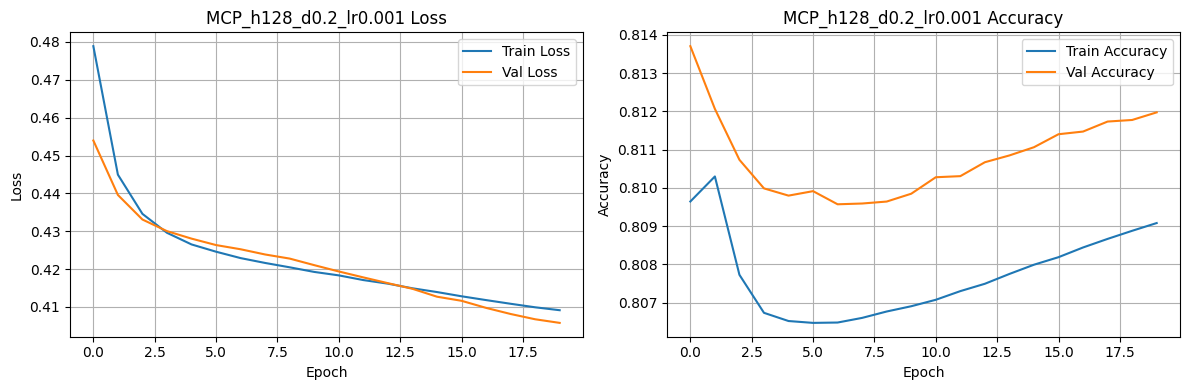

MCP_h128_d0.2_lr0.001 - Test loss: 0.4120, Test accuracy: 0.8087

Testing MCP: hidden_units=128, dropout_rate=0.2, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4919 - accuracy: 0.8081 - val_loss: 0.4676 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4575 - accuracy: 0.8116 - val_loss: 0.4511 - val_accuracy: 0.8137
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4441 - accuracy: 0.8109 - val_loss: 0.4414 - val_accuracy: 0.8128
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4362 - accuracy: 0.8091 - val_loss: 0.4354 - val_accuracy: 0.8116
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4312 - accuracy: 0.8078 - val_loss: 0.4321 - val_accuracy: 0.8105
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4280 - accuracy: 0.8071 - val_loss: 0.4296 - val_accuracy: 0.8098
Epoch 7/20
7

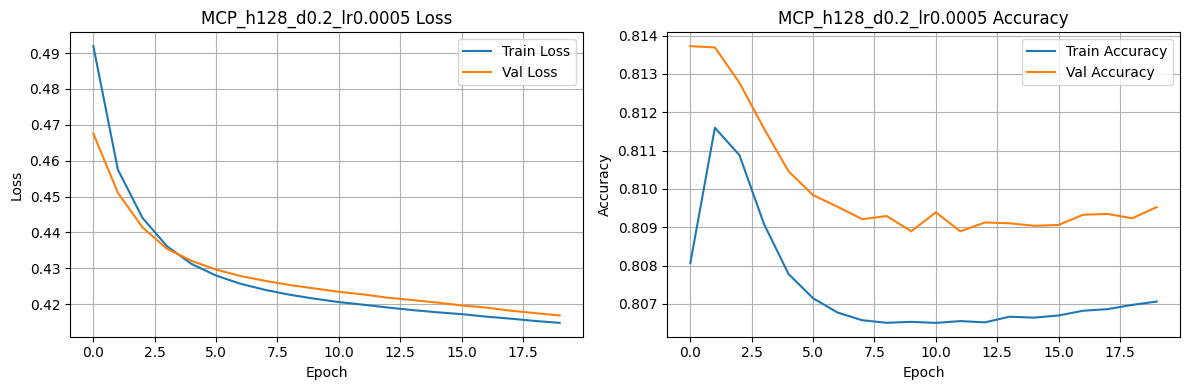

MCP_h128_d0.2_lr0.0005 - Test loss: 0.4229, Test accuracy: 0.8064

Testing MCP: hidden_units=256, dropout_rate=0.0, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4626 - accuracy: 0.8096 - val_loss: 0.4379 - val_accuracy: 0.8098
Epoch 2/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4162 - accuracy: 0.8029 - val_loss: 0.4229 - val_accuracy: 0.7988
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3997 - accuracy: 0.8001 - val_loss: 0.4177 - val_accuracy: 0.7963
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3914 - accuracy: 0.8009 - val_loss: 0.4165 - val_accuracy: 0.7956
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3866 - accuracy: 0.8021 - val_loss: 0.4155 - val_accuracy: 0.7941
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3834 - accuracy: 0.8032 - val_loss: 0.4151 - val_accuracy: 0.7939
Epoch 7/20
7

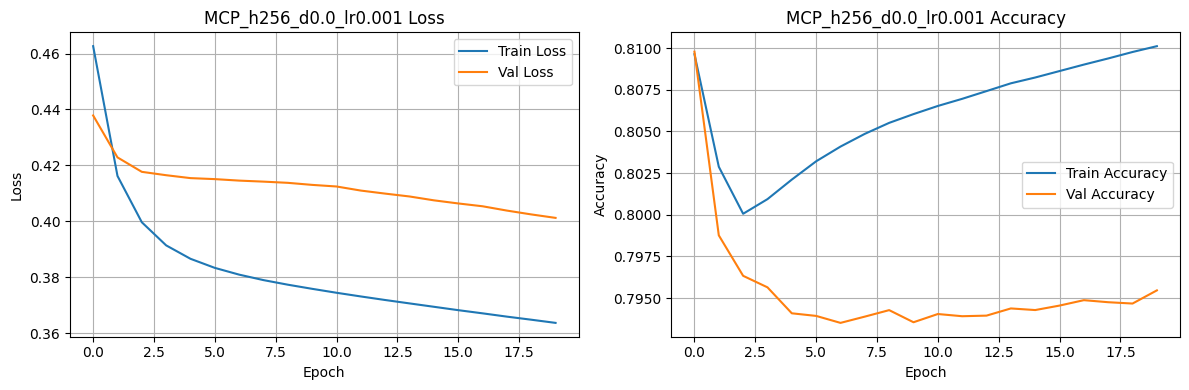

MCP_h256_d0.0_lr0.001 - Test loss: 0.4072, Test accuracy: 0.7923

Testing MCP: hidden_units=256, dropout_rate=0.0, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4794 - accuracy: 0.8094 - val_loss: 0.4543 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4352 - accuracy: 0.8097 - val_loss: 0.4336 - val_accuracy: 0.8074
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4131 - accuracy: 0.8022 - val_loss: 0.4223 - val_accuracy: 0.7996
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 0.3999 - accuracy: 0.7992 - val_loss: 0.4171 - val_accuracy: 0.7953
Epoch 5/20
750/750 [==============================] - 6s 7ms/step - loss: 0.3922 - accuracy: 0.7989 - val_loss: 0.4143 - val_accuracy: 0.7940
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3872 - accuracy: 0.7995 - val_loss: 0.4133 - val_accuracy: 0.7928
Epoch 7/20
7

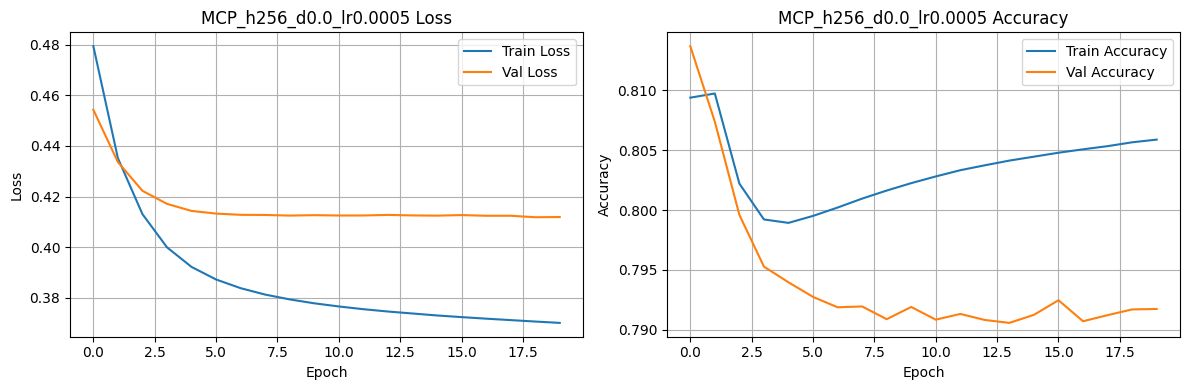

MCP_h256_d0.0_lr0.0005 - Test loss: 0.4182, Test accuracy: 0.7885

Testing MCP: hidden_units=256, dropout_rate=0.2, learning_rate=0.001
Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 0.4679 - accuracy: 0.8099 - val_loss: 0.4427 - val_accuracy: 0.8128
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4292 - accuracy: 0.8067 - val_loss: 0.4269 - val_accuracy: 0.8082
Epoch 3/20
750/750 [==============================] - 6s 7ms/step - loss: 0.4169 - accuracy: 0.8043 - val_loss: 0.4218 - val_accuracy: 0.8051
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4107 - accuracy: 0.8041 - val_loss: 0.4184 - val_accuracy: 0.8049
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4071 - accuracy: 0.8045 - val_loss: 0.4165 - val_accuracy: 0.8042
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4044 - accuracy: 0.8050 - val_loss: 0.4149 - val_accuracy: 0.8043
Epoch 7/20
7

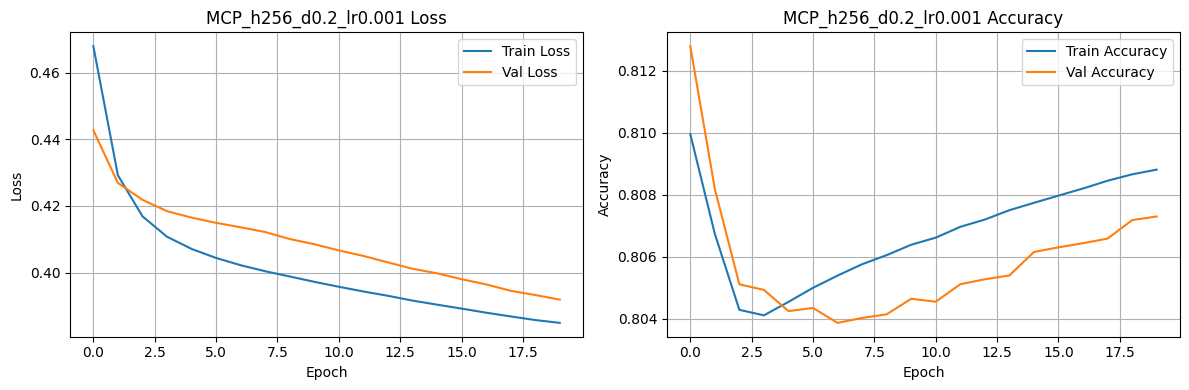

MCP_h256_d0.2_lr0.001 - Test loss: 0.3982, Test accuracy: 0.8042

Testing MCP: hidden_units=256, dropout_rate=0.2, learning_rate=0.0005
Epoch 1/20
750/750 [==============================] - 7s 8ms/step - loss: 0.4818 - accuracy: 0.8092 - val_loss: 0.4569 - val_accuracy: 0.8137
Epoch 2/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4437 - accuracy: 0.8110 - val_loss: 0.4382 - val_accuracy: 0.8121
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4271 - accuracy: 0.8075 - val_loss: 0.4284 - val_accuracy: 0.8079
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4175 - accuracy: 0.8052 - val_loss: 0.4222 - val_accuracy: 0.8062
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.4117 - accuracy: 0.8045 - val_loss: 0.4188 - val_accuracy: 0.8052
Epoch 6/20
750/750 [==============================] - 6s 8ms/step - loss: 0.4079 - accuracy: 0.8044 - val_loss: 0.4168 - val_accuracy: 0.8038
Epoch 7/20
7

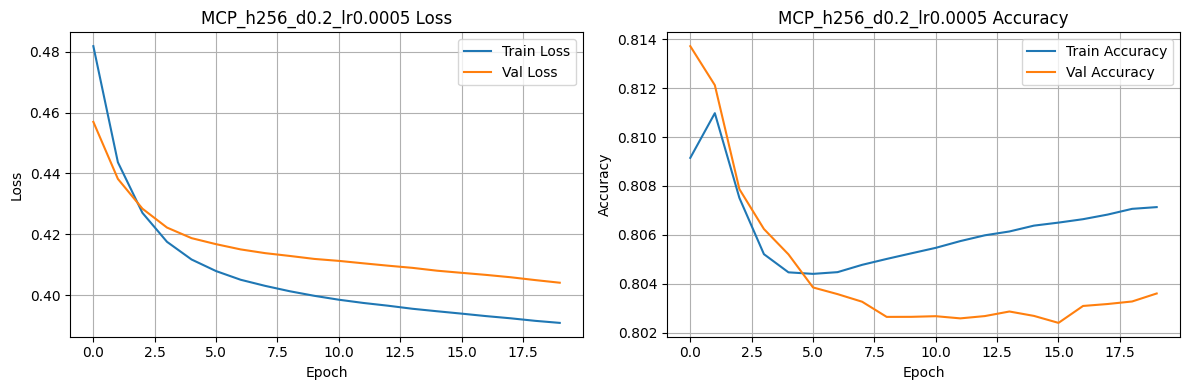

MCP_h256_d0.2_lr0.0005 - Test loss: 0.4103, Test accuracy: 0.8002

Grid Search Results:
hidden_units=64, dropout_rate=0.0, learning_rate=0.001, val_accuracy=0.8137, test_accuracy=0.8019, test_loss=0.4346
hidden_units=64, dropout_rate=0.0, learning_rate=0.0005, val_accuracy=0.8137, test_accuracy=0.8014, test_loss=0.4365
hidden_units=64, dropout_rate=0.2, learning_rate=0.001, val_accuracy=0.8137, test_accuracy=0.8104, test_loss=0.4315
hidden_units=64, dropout_rate=0.2, learning_rate=0.0005, val_accuracy=0.8137, test_accuracy=0.8096, test_loss=0.4383
hidden_units=128, dropout_rate=0.0, learning_rate=0.001, val_accuracy=0.8133, test_accuracy=0.7952, test_loss=0.4164
hidden_units=128, dropout_rate=0.0, learning_rate=0.0005, val_accuracy=0.8137, test_accuracy=0.7919, test_loss=0.4246
hidden_units=128, dropout_rate=0.2, learning_rate=0.001, val_accuracy=0.8137, test_accuracy=0.8087, test_loss=0.4120
hidden_units=128, dropout_rate=0.2, learning_rate=0.0005, val_accuracy=0.8137, test_accuracy=0

In [ ]:
from itertools import product

# Build MLP model with configurable parameters
def build_mlp_model(hidden_units=64, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential([
        Flatten(input_shape=(40, 40, 1)),  # Flatten 40x40x1 to 1600
        Dense(hidden_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1600, activation='sigmoid'),  # Output 1600 (40x40)
        tf.keras.layers.Reshape((40, 40, 1))  # Reshape to (40, 40, 1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Grid search for MLP hyperparameter tuning
def tune_mlp_hyperparameters(train_dataset, val_dataset, test_dataset):
    hidden_units_list = [64, 128, 256]
    dropout_rates = [0.0, 0.2]
    learning_rates = [0.001, 0.0005]
    
    best_val_acc = 0
    best_params = None
    results = []
    
    for hidden_units, dropout_rate, learning_rate in product(hidden_units_list, dropout_rates, learning_rates):
        print(f"\nTesting MLP: hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
        model = build_mlp_model(hidden_units, dropout_rate, learning_rate)
        model_name = f"MLP_h{hidden_units}_d{dropout_rate}_lr{learning_rate}"
        history = train_and_plot(model, train_dataset, val_dataset, model_name, epochs=20)
        
        test_loss, test_acc = evaluate_model(model, test_dataset, model_name)
        val_acc = max(history.history['val_accuracy'])
        
        results.append({
            'hidden_units': hidden_units,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
            'test_loss': test_loss
        })
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (hidden_units, dropout_rate, learning_rate)
    
    print("\nGrid Search Results:")
    for result in results:
        print(f"hidden_units={result['hidden_units']}, dropout_rate={result['dropout_rate']}, "
              f"learning_rate={result['learning_rate']}, val_accuracy={result['val_accuracy']:.4f}, "
              f"test_accuracy={result['test_accuracy']:.4f}, test_loss={result['test_loss']:.4f}")
    
    print(f"\nBest parameters: hidden_units={best_params[0]}, dropout_rate={best_params[1]}, "
          f"learning_rate={best_params[2]}, best_val_accuracy={best_val_acc:.4f}")
    
    return best_params, results

# Tune MLP hyperparameters
print("\nTuning MLP hyperparameters...")
best_params, results = tune_mlp_hyperparameters(train_dataset, val_dataset, test_dataset)

### 4.5 Try with Deeper MLP

The hyper-parameter tuning seems not improving the model's performance.

How about adding another hidden layer?

Training Deep MLP model...
Epoch 1/50
750/750 [==============================] - 5s 6ms/step - loss: 0.5206 - accuracy: 0.7951 - val_loss: 0.4925 - val_accuracy: 0.8118
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4846 - accuracy: 0.8114 - val_loss: 0.4798 - val_accuracy: 0.8118
Epoch 3/50
750/750 [==============================] - 7s 10ms/step - loss: 0.4760 - accuracy: 0.8114 - val_loss: 0.4756 - val_accuracy: 0.8118
Epoch 4/50
750/750 [==============================] - 7s 9ms/step - loss: 0.4734 - accuracy: 0.8114 - val_loss: 0.4740 - val_accuracy: 0.8118
Epoch 5/50
750/750 [==============================] - 7s 10ms/step - loss: 0.4718 - accuracy: 0.8114 - val_loss: 0.4726 - val_accuracy: 0.8118
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.4702 - accuracy: 0.8114 - val_loss: 0.4711 - val_accuracy: 0.8118
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.4682 - accuracy: 0.8114 - val_loss: 0.4692 

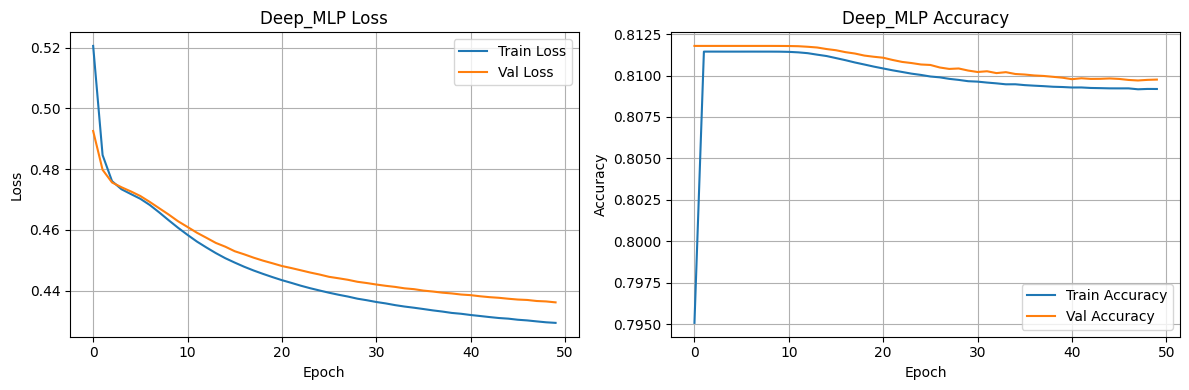

Deep_MLP - Test loss: 0.4397, Test accuracy: 0.8080


(0.43971964716911316, 0.8080006241798401)

In [86]:
# Build Deep MLP model (2 hidden layers, 128+64 units)
def build_deep_mlp_model():
    model = Sequential([
        Flatten(input_shape=(40, 40, 1)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1600, activation='sigmoid'),
        tf.keras.layers.Reshape((40, 40, 1))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Deep MLP
deep_mlp_model = build_deep_mlp_model()
print("Training Deep MLP model...")
deep_mlp_history = train_and_plot(deep_mlp_model, train_dataset, val_dataset, 'Deep_MLP', epochs=50)
evaluate_model(deep_mlp_model, test_dataset, 'Deep_MLP')

### 4.6 Shallow CNN (4 Filters)

Training Shallow CNN model...
Epoch 1/10
750/750 [==============================] - 4s 4ms/step - loss: 0.5422 - accuracy: 0.8116 - val_loss: 0.4257 - val_accuracy: 0.8137
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.3579 - accuracy: 0.8116 - val_loss: 0.3077 - val_accuracy: 0.8137
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2895 - accuracy: 0.8116 - val_loss: 0.2699 - val_accuracy: 0.8137
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2593 - accuracy: 0.8338 - val_loss: 0.2437 - val_accuracy: 0.9187
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2326 - accuracy: 0.9184 - val_loss: 0.2171 - val_accuracy: 0.9197
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2085 - accuracy: 0.9186 - val_loss: 0.1950 - val_accuracy: 0.9197
Epoch 7/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1860 - accuracy: 0.9186 - val_loss: 0.1721

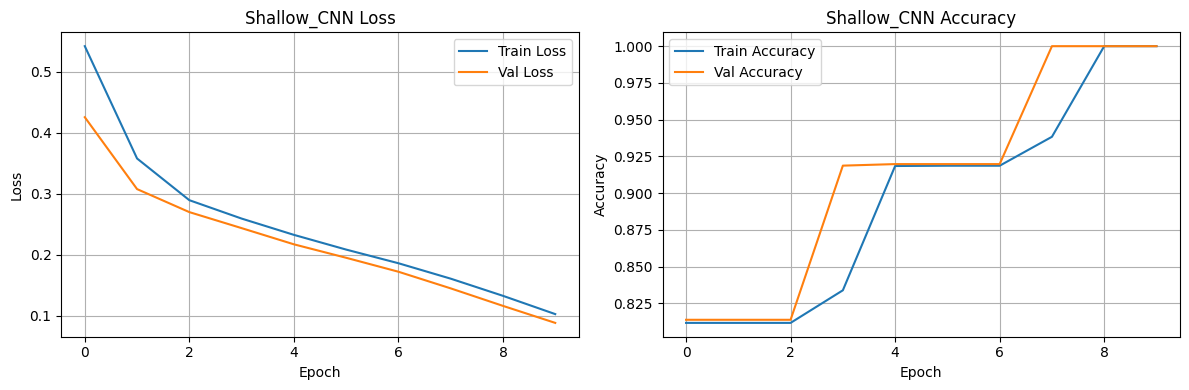

Shallow_CNN - Test loss: 0.0898, Test accuracy: 1.0000


(0.0898057371377945, 1.0)

In [64]:
# Build Shallow CNN model (new baseline)
def build_shallow_cnn_model():
    model = Sequential([
        Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(40, 40, 1)),
        Conv2D(1, (1, 1), padding='same', activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Shallow CNN
shallow_cnn_model = build_shallow_cnn_model()
print("Training Shallow CNN model...")
shallow_cnn_history = train_and_plot(shallow_cnn_model, train_dataset, val_dataset, 'Shallow_CNN')
evaluate_model(shallow_cnn_model, test_dataset, 'Shallow_CNN')

In [70]:
shallow_cnn_model.save('shallow_cnn_model_40x40.h5')

In [71]:
shallow_cnn_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 40, 4)         40        
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 1)         5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [72]:
shallow_cnn_model.get_weights()

[array([[[[ 0.7024347 , -0.6105906 , -0.48901403, -0.5002317 ]],
 
         [[ 0.696237  , -0.6105533 , -0.4891047 , -0.50044584]],
 
         [[ 0.702477  , -0.6107493 , -0.48917753, -0.50045455]]],
 
 
        [[[ 0.69450307, -0.61074615, -0.48893526, -0.50033146]],
 
         [[-0.09097183, -0.6106862 , -0.48920158, -0.5002523 ]],
 
         [[ 0.6940948 , -0.61062914, -0.48922017, -0.5005394 ]]],
 
 
        [[[ 0.70279676, -0.61090845, -0.48911434, -0.5005159 ]],
 
         [[ 0.6945813 , -0.6107829 , -0.4892825 , -0.5006647 ]],
 
         [[ 0.7035626 , -0.61074805, -0.48937503, -0.50063616]]]],
       dtype=float32),
 array([-1.7658577,  1.8318694,  1.4672227,  1.5011986], dtype=float32),
 array([[[[-2.5142596],
          [-2.8132772],
          [-3.2192602],
          [-3.4009645]]]], dtype=float32),
 array([1.7493201], dtype=float32)]

### 4.7 Larger and Deeper CNN (8 + 16 filters)

Training CNN model...
Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 0.2180 - accuracy: 0.9190 - val_loss: 0.0417 - val_accuracy: 0.9909
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 0.0194 - accuracy: 0.9956 - val_loss: 0.0078 - val_accuracy: 0.9984
Epoch 3/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 4/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 9.1791e-04 - val_accuracy: 0.9999
Epoch 5/10
750/750 [==============================] - 6s 8ms/step - loss: 6.4352e-04 - accuracy: 1.0000 - val_loss: 4.3296e-04 - val_accuracy: 1.0000
Epoch 6/10
750/750 [==============================] - 6s 9ms/step - loss: 3.2354e-04 - accuracy: 1.0000 - val_loss: 2.2579e-04 - val_accuracy: 1.0000
Epoch 7/10
750/750 [==============================] - 7s 9ms/step - loss: 1.7777e-04 - accuracy: 1.0000 - 

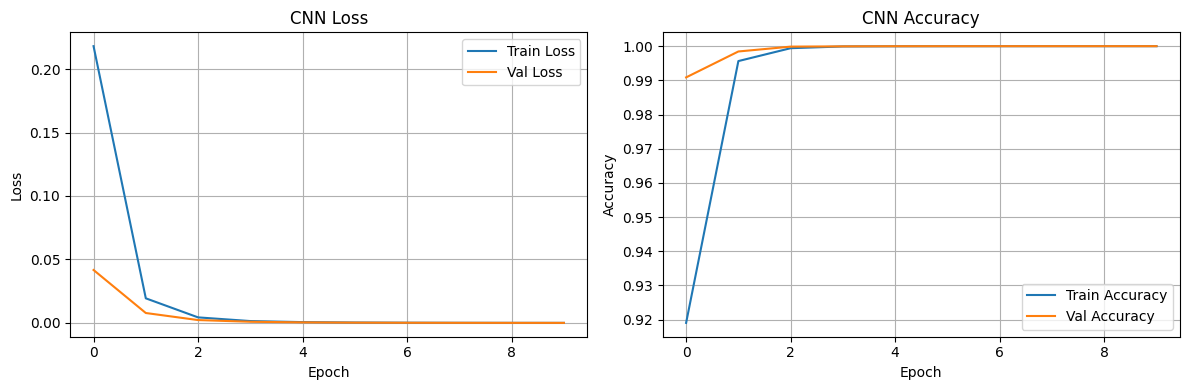

CNN - Test loss: 0.0000, Test accuracy: 1.0000


(3.361184280947782e-05, 0.999997079372406)

In [65]:
# Build CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(40, 40, 1)),
        Conv2D(16, (3, 3), padding='same', activation='relu'),
        Conv2D(1, (1, 1), padding='same', activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train CNN
cnn_model = build_cnn_model()
print("Training CNN model...")
cnn_history = train_and_plot(cnn_model, train_dataset, val_dataset, 'CNN')

# Evaluate models
evaluate_model(cnn_model, test_dataset, 'CNN')

In [66]:
# Save the model
cnn_model.save('cnn_model_40x40.h5')

### 4.8 Use the CNN model to predict a few random grid inputs

Loading model from cnn_model_40x40.h5...
Generating and predicting random grids...


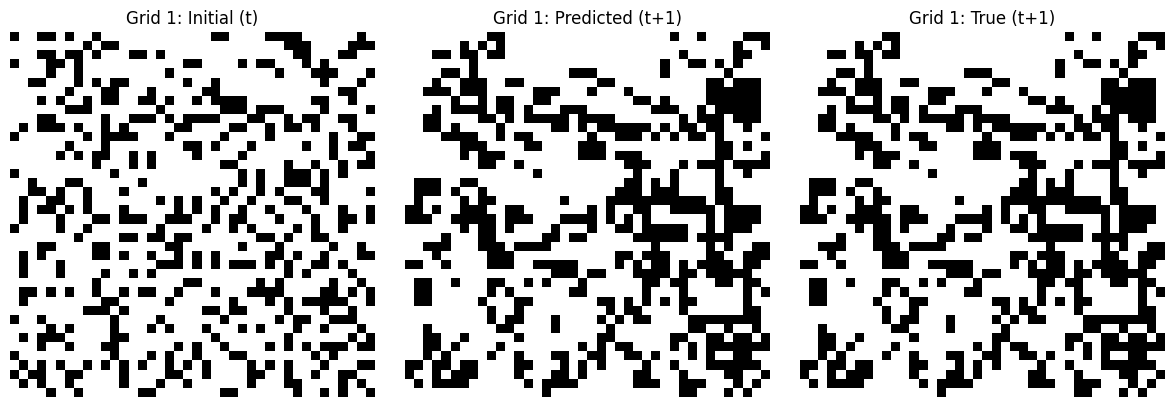

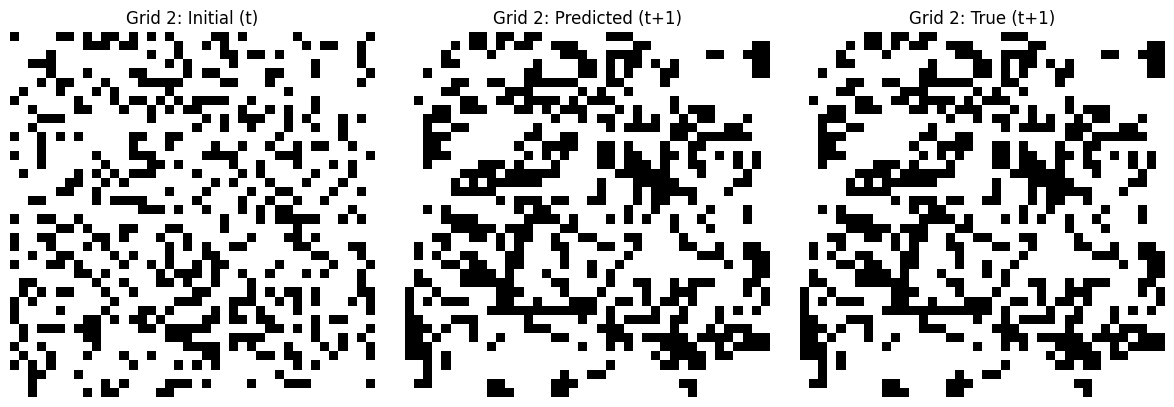

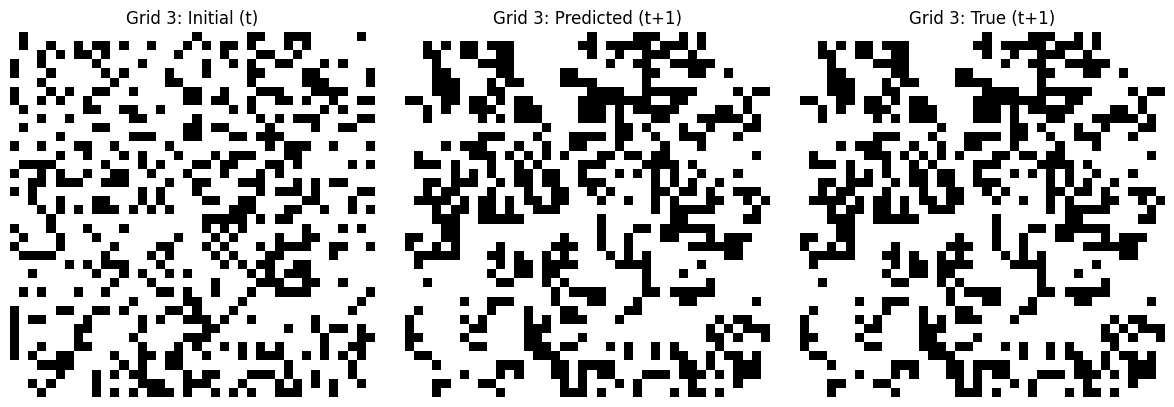

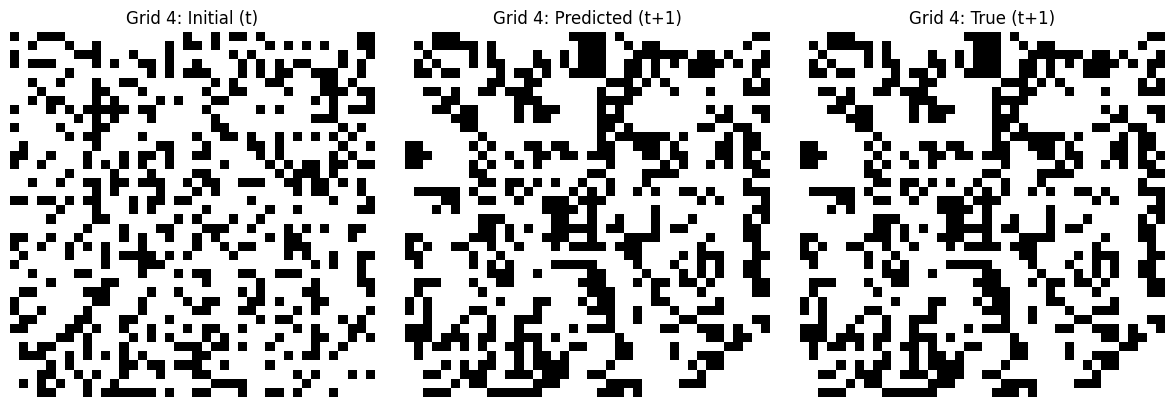

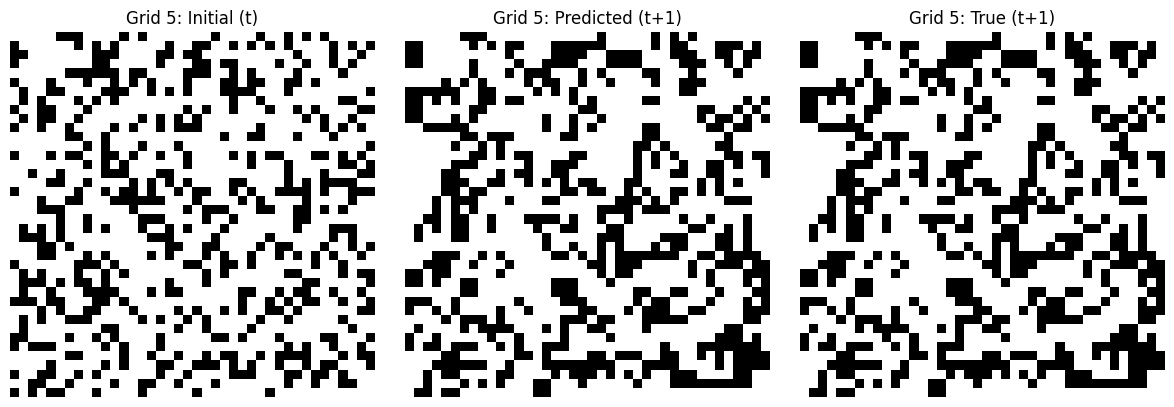

In [67]:
from tensorflow.keras.models import load_model

# Generate random grids
def generate_random_grids(num_grids=5, grid_size=40, live_prob=0.3):
    grids = np.random.choice([0, 1], size=(num_grids, grid_size, grid_size), p=[1-live_prob, live_prob])
    return grids  # Shape: (num_grids, 40, 40)

# Predict and visualize
def predict_and_visualize(model, num_grids=5, grid_size=40, live_prob=0.3):
    # Generate random grids
    grids = generate_random_grids(num_grids, grid_size, live_prob)
    
    # Prepare inputs for prediction
    inputs = grids[..., np.newaxis]  # Shape: (5, 40, 40, 1)
    
    # Predict next state
    predictions = model.predict(inputs, verbose=0)  # Shape: (5, 40, 40, 1)
    predictions = (predictions > 0.5).astype(np.int32)  # Threshold to 0/1
    
    # Compute true next state
    true_next = np.array([update_grid(grid) for grid in grids])  # Shape: (5, 40, 40)
    
    # Visualize
    for i in range(num_grids):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        
        ax1.imshow(grids[i], cmap='binary')
        ax1.set_title(f'Grid {i+1}: Initial (t)')
        ax1.axis('off')
        
        ax2.imshow(predictions[i].squeeze(), cmap='binary')
        ax2.set_title(f'Grid {i+1}: Predicted (t+1)')
        ax2.axis('off')
        
        ax3.imshow(true_next[i], cmap='binary')
        ax3.set_title(f'Grid {i+1}: True (t+1)')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'prediction_grid_{i+1}.png')
        plt.show()
    
    return grids, predictions, true_next

model_path = 'cnn_model_40x40.h5'
print(f"Loading model from {model_path}...")
model = load_model(model_path)

# Predict and visualize random grids
print("Generating and predicting random grids...")
grids, predictions, true_next = predict_and_visualize(model, num_grids=5, grid_size=40, live_prob=0.3)


In [68]:
cnn_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 40, 40, 8)         80        
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 16)        1168      
                                                                 
 conv2d_22 (Conv2D)          (None, 40, 40, 1)         17        
                                                                 
Total params: 1,265
Trainable params: 1,265
Non-trainable params: 0
_________________________________________________________________


In [69]:
shallow_cnn_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 40, 4)         40        
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 1)         5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


### 4.9 Try a Smaller CNN model (1 Filter)

We can try smaller models to see if it can still achieve high accuracy. If it does, it means it will be more efficient than larger models.

Training Minimal CNN model...
Epoch 1/30
750/750 [==============================] - 5s 6ms/step - loss: 0.6168 - accuracy: 0.8005 - val_loss: 0.5738 - val_accuracy: 0.8117
Epoch 2/30
750/750 [==============================] - 6s 8ms/step - loss: 0.5425 - accuracy: 0.8091 - val_loss: 0.5125 - val_accuracy: 0.8213
Epoch 3/30
750/750 [==============================] - 7s 9ms/step - loss: 0.4908 - accuracy: 0.8429 - val_loss: 0.4683 - val_accuracy: 0.8494
Epoch 4/30
750/750 [==============================] - 7s 9ms/step - loss: 0.4536 - accuracy: 0.8321 - val_loss: 0.4364 - val_accuracy: 0.8303
Epoch 5/30
750/750 [==============================] - 6s 9ms/step - loss: 0.4269 - accuracy: 0.8330 - val_loss: 0.4136 - val_accuracy: 0.8485
Epoch 6/30
750/750 [==============================] - 7s 9ms/step - loss: 0.4078 - accuracy: 0.8517 - val_loss: 0.3974 - val_accuracy: 0.8650
Epoch 7/30
750/750 [==============================] - 7s 9ms/step - loss: 0.3944 - accuracy: 0.8594 - val_loss: 0.3861

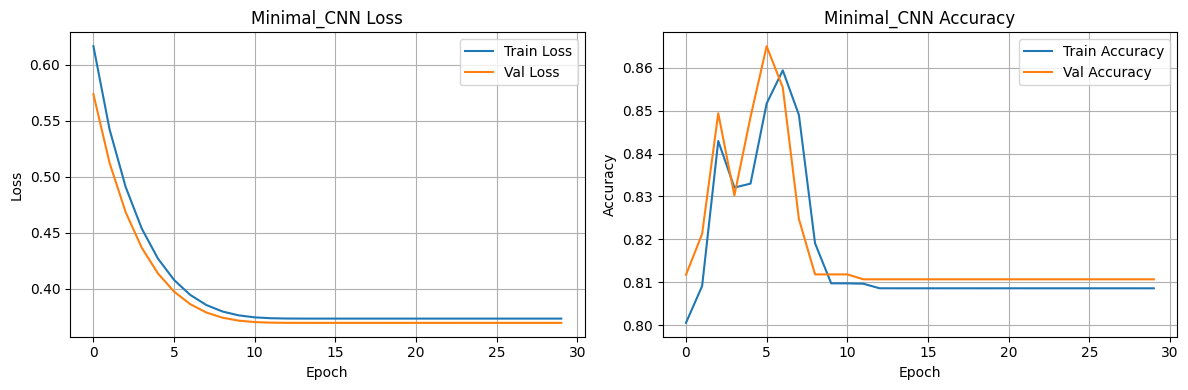

Minimal_CNN - Test loss: 0.3754, Test accuracy: 0.8071


(0.375375360250473, 0.8070681095123291)

In [74]:
# Build Minimal CNN model (simplest, 1 filter)
def build_minimal_cnn_model():
    model = Sequential([
        Conv2D(1, (3, 3), padding='same', activation='sigmoid', input_shape=(40, 40, 1))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Minimal CNN
minimal_cnn_model = build_minimal_cnn_model()
print("Training Minimal CNN model...")
minimal_cnn_history = train_and_plot(minimal_cnn_model, train_dataset, val_dataset, 'Minimal_CNN', epochs=30)
evaluate_model(minimal_cnn_model, test_dataset, 'Minimal_CNN')

### 4.10 CNN Model with 2 Filters

Looks like 1 filter is not enough, now let's increase to 2 filters.

Training Double Filter CNN model...
Epoch 1/30
750/750 [==============================] - 5s 6ms/step - loss: 0.6433 - accuracy: 0.7959 - val_loss: 0.5966 - val_accuracy: 0.8118
Epoch 2/30
750/750 [==============================] - 4s 5ms/step - loss: 0.5594 - accuracy: 0.8330 - val_loss: 0.5268 - val_accuracy: 0.8523
Epoch 3/30
750/750 [==============================] - 3s 4ms/step - loss: 0.5002 - accuracy: 0.8405 - val_loss: 0.4735 - val_accuracy: 0.8191
Epoch 4/30
750/750 [==============================] - 3s 4ms/step - loss: 0.4525 - accuracy: 0.8207 - val_loss: 0.4342 - val_accuracy: 0.8267
Epoch 5/30
750/750 [==============================] - 3s 4ms/step - loss: 0.4206 - accuracy: 0.8412 - val_loss: 0.4091 - val_accuracy: 0.8461
Epoch 6/30
750/750 [==============================] - 3s 4ms/step - loss: 0.4004 - accuracy: 0.8421 - val_loss: 0.3932 - val_accuracy: 0.8401
Epoch 7/30
750/750 [==============================] - 3s 4ms/step - loss: 0.3876 - accuracy: 0.8381 - val_loss: 

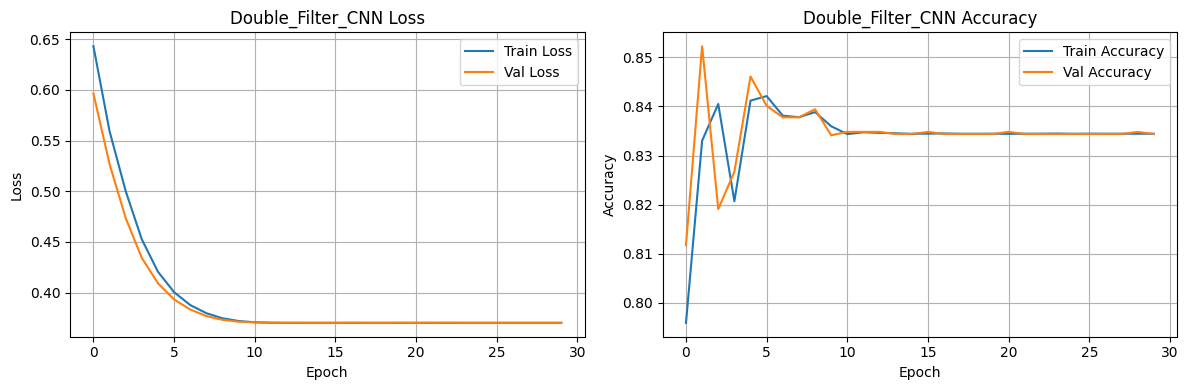

Double_Filter_CNN - Test loss: 0.3718, Test accuracy: 0.8334


(0.37176647782325745, 0.8333783149719238)

In [87]:
# Build Double Filter CNN model (slightly more complex, 2 filters)
def build_double_filter_cnn_model():
    model = Sequential([
        Conv2D(2, (3, 3), padding='same', activation='relu', input_shape=(40, 40, 1)),
        Conv2D(1, (1, 1), padding='same', activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Double Filter CNN
double_filter_cnn_model = build_double_filter_cnn_model()
print("Training Double Filter CNN model...")
double_filter_cnn_history = train_and_plot(double_filter_cnn_model, train_dataset, val_dataset, 'Double_Filter_CNN', epochs=30)
evaluate_model(double_filter_cnn_model, test_dataset, 'Double_Filter_CNN')

### 4.11 CNN with 3 Filters

Training Triple Filter CNN model...
Epoch 1/30
750/750 [==============================] - 6s 8ms/step - loss: 0.5138 - accuracy: 0.8116 - val_loss: 0.4025 - val_accuracy: 0.8137
Epoch 2/30
750/750 [==============================] - 7s 10ms/step - loss: 0.3569 - accuracy: 0.8116 - val_loss: 0.3207 - val_accuracy: 0.8137
Epoch 3/30
750/750 [==============================] - 7s 10ms/step - loss: 0.3001 - accuracy: 0.8116 - val_loss: 0.2716 - val_accuracy: 0.8137
Epoch 4/30
750/750 [==============================] - 7s 10ms/step - loss: 0.2573 - accuracy: 0.8116 - val_loss: 0.2431 - val_accuracy: 0.8137
Epoch 5/30
750/750 [==============================] - 7s 10ms/step - loss: 0.2388 - accuracy: 0.8390 - val_loss: 0.2301 - val_accuracy: 0.8779
Epoch 6/30
750/750 [==============================] - 8s 10ms/step - loss: 0.2284 - accuracy: 0.8762 - val_loss: 0.2219 - val_accuracy: 0.8779
Epoch 7/30
750/750 [==============================] - 7s 10ms/step - loss: 0.2218 - accuracy: 0.8762 - val_

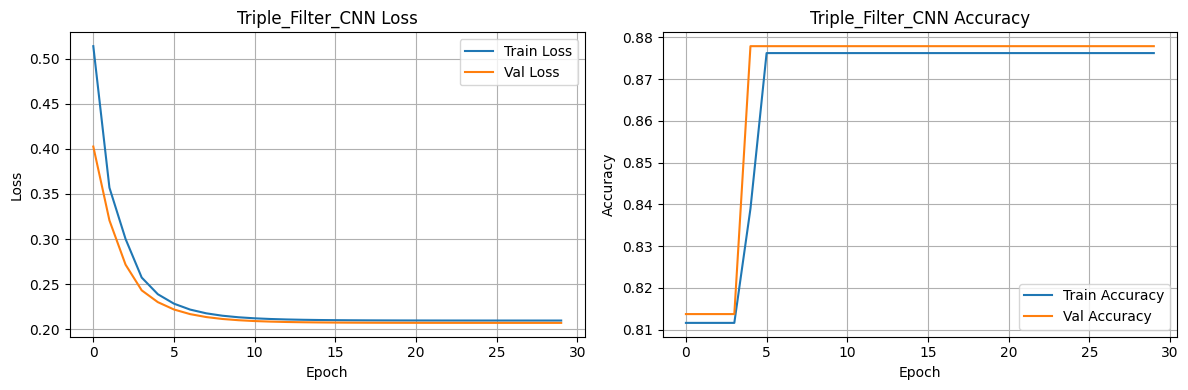

Triple_Filter_CNN - Test loss: 0.2111, Test accuracy: 0.8752


(0.21109174191951752, 0.8752145767211914)

In [77]:
# Build Triple Filter CNN model (3 filters, 34 parameters)
def build_triple_filter_cnn_model():
    model = Sequential([
        Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=(40, 40, 1)),
        Conv2D(1, (1, 1), padding='same', activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Triple Filter CNN
triple_filter_cnn_model = build_triple_filter_cnn_model()
print("Training Triple Filter CNN model...")
triple_filter_cnn_history = train_and_plot(triple_filter_cnn_model, train_dataset, val_dataset, 'Triple_Filter_CNN', epochs=30)
evaluate_model(triple_filter_cnn_model, test_dataset, 'Triple_Filter_CNN')

## 5. Summary of Results

Model | Parameters | Accuracy
------|------------|----------------------------------
MLP (baseline, 64 hidden units) | | 80%
MLP (After hyper-parameter tuning) | | 81%
MLP with 2 hidden layers (128 + 64 units) | | 80%
Deeper CNN (8 + 16 filters) | | 100%
CNN with 1 filters | 10 | 81~87%, underfit
CNN with 2 filters | 23 | 81~87%, underfit
CNN with 3 filters | 34 | 81~87.5%, underfit
**CNN with 4 filters** | 45 | 100%, stable

`CNN with 4 filters` is the smallest model we achieved with `100%` accuracy.

## 6. Conclusions

In this project, we explored how to use several `Deep Learning` models to learn the rules of `Game of Life`, and the result turns out to be quite successful. (100% accuracy)

### Data

We first generated 1,000 samples of training data on 40x40 game grids, with 30 steps as the sequence length.

We then did some EDA to understand the data itself and find some interesting patterns.

### Model

In model training part, we tried with `MLP` and `CNN` with a few model variations, and hyper-parameter tuning.

It turns out that, `MLP` does not perform very well, with only `81%` accuracy. With hyper-parameter tuning, we tried more hidden units, or adding one more hidden layer, the model still cannot improve. This may due to the limitation of `MLP` by design, that it cannot effectively learn spatial relationships.

On the other hand, `CNN` with `3x3` filters are very effective to learn the rule of this game. This is because, for the next state of each cell, it is only determined by the state of the 8 neighbor cells, which is a local relationship, and perfectly fall within a `3x3` region. It can be easily learned by `3x3` convolutional filters.

Next we explored the `CNN` model size, trying to find a compact model which both can achieve high accuracy, and also is as small as possible.

We ended up with the `CNN with 4 3x3 filters` model, which is the best so far, with `100%` accuracy and only `45` parameters.

### Future Explorations

Looking forward, many other interesting things can be explored in the future, such as,

- Train models for multipe-step predictions, LSTM might be useful in this case.
- Train models for competitive board games, like Tic-Tac-Toe (simple), or Othello (harder).
- Explore other variations of Game of Life, and train models for it.
